In [27]:
import numpy as np
import pandas as pd
import seaborn as sns
import time
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Lasso
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import Pipeline
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
from google.colab import files
import pandas as pd

# Upload the CSV file
uploaded = files.upload()

# Once uploaded, read the CSV file into a pandas DataFrame
df = pd.read_csv(next(iter(uploaded)))

Saving customer_feedback_satisfaction.csv to customer_feedback_satisfaction.csv


In [3]:
df.shape

(38444, 11)

In [4]:
df

,CustomerID,Age,Gender,Country,Income,ProductQuality,ServiceQuality,PurchaseFrequency,FeedbackScore,LoyaltyLevel,SatisfactionScore
0,1,56,Male,UK,83094,5,8,5,Low,Bronze,100.00
1,2,69,Male,UK,86860,10,2,8,Medium,Gold,100.00
2,3,46,Female,USA,60173,8,10,18,Medium,Silver,100.00
3,4,32,Female,UK,73884,7,10,16,Low,Gold,100.00
4,5,60,Male,UK,97546,6,4,13,Low,Bronze,82.00
...,...,...,...,...,...,...,...,...,...,...,...
38439,38440,55,Female,USA,80880,6,3,14,High,Silver,75.85
38440,38441,44,Male,Canada,42845,5,10,1,Low,Silver,100.00
38441,38442,43,Female,USA,71433,7,9,7,Medium,Bronze,100.00
38442,38443,28,Female,USA,105587,7,5,16,High,Silver,100.00


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38444 entries, 0 to 38443
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CustomerID         38444 non-null  int64  
 1   Age                38444 non-null  int64  
 2   Gender             38444 non-null  object 
 3   Country            38444 non-null  object 
 4   Income             38444 non-null  int64  
 5   ProductQuality     38444 non-null  int64  
 6   ServiceQuality     38444 non-null  int64  
 7   PurchaseFrequency  38444 non-null  int64  
 8   FeedbackScore      38444 non-null  object 
 9   LoyaltyLevel       38444 non-null  object 
 10  SatisfactionScore  38444 non-null  float64
dtypes: float64(1), int64(6), object(4)
memory usage: 3.2+ MB


In [6]:
df = df.drop_duplicates()
# Drop 'CustomerID' as it's a unique identifier and not useful for modeling
df.drop('CustomerID', axis=1, inplace=True)

In [7]:
df.isnull().sum() #no missing values

,0
Age,0
Gender,0
Country,0
Income,0
ProductQuality,0
ServiceQuality,0
PurchaseFrequency,0
FeedbackScore,0
LoyaltyLevel,0
SatisfactionScore,0


In [8]:
for col in df.columns:
    unique_values = df[col].unique()
    print(f"Unique values in '{col}': {unique_values}\n")

Unique values in 'Age': [56 69 46 32 60 25 38 36 40 28 41 53 57 20 39 19 61 47 55 50 29 42 66 44
 59 45 33 64 68 54 24 26 35 21 31 67 43 37 52 34 23 51 27 48 65 62 58 18
 22 30 49 63]

Unique values in 'Gender': ['Male' 'Female']

Unique values in 'Country': ['UK' 'USA' 'France' 'Germany' 'Canada']

Unique values in 'Income': [ 83094  86860  60173 ...  80880 105587 105379]

Unique values in 'ProductQuality': [ 5 10  8  7  6  9  1  2  3  4]

Unique values in 'ServiceQuality': [ 8  2 10  4  7  6  3  5  9  1]

Unique values in 'PurchaseFrequency': [ 5  8 18 16 13 19 11 10 12 20  3 17 15  7  2 14  1  4  9  6]

Unique values in 'FeedbackScore': ['Low' 'Medium' 'High']

Unique values in 'LoyaltyLevel': ['Bronze' 'Gold' 'Silver']

Unique values in 'SatisfactionScore': [100.    82.    80.71 ...  38.64  45.56  46.33]



In [9]:
# Initialize LabelEncoder for binary categorical variables
le = LabelEncoder()
# Define mappings and initialize encoders
loyalty_map = {'Bronze': 0, 'Silver': 1, 'Gold': 2}
feedback_map = {'Low':0, 'Medium':1, 'High':2}

# Apply mappings and encodings in one step
df['Gender'] = LabelEncoder().fit_transform(df['Gender'])
df['LoyaltyLevel'] = df['LoyaltyLevel'].map(loyalty_map)
df['FeedbackScore'] = df['FeedbackScore'].map(feedback_map)

# Apply one-hot encoding for 'Country' and convert booleans to integers
df = pd.get_dummies(df, columns=['Country'], drop_first=True).astype(int) #dropped column for Canada to avoid multicollinearity
df = df.replace({True: 1, False: 0})
print("Data after Encoding:")
display(df.head())

Data after Encoding:


,Age,Gender,Income,ProductQuality,ServiceQuality,PurchaseFrequency,FeedbackScore,LoyaltyLevel,SatisfactionScore,Country_France,Country_Germany,Country_UK,Country_USA
0,56,1,83094,5,8,5,0,0,100,0,0,1,0
1,69,1,86860,10,2,8,1,2,100,0,0,1,0
2,46,0,60173,8,10,18,1,1,100,0,0,0,1
3,32,0,73884,7,10,16,0,2,100,0,0,1,0
4,60,1,97546,6,4,13,0,0,82,0,0,1,0


In [10]:
cols = [col for col in df.columns if col != 'SatisfactionScore'] + ['SatisfactionScore'] # shift target column to the end
df = df[cols]
df.head()

,Age,Gender,Income,ProductQuality,ServiceQuality,PurchaseFrequency,FeedbackScore,LoyaltyLevel,Country_France,Country_Germany,Country_UK,Country_USA,SatisfactionScore
0,56,1,83094,5,8,5,0,0,0,0,1,0,100
1,69,1,86860,10,2,8,1,2,0,0,1,0,100
2,46,0,60173,8,10,18,1,1,0,0,0,1,100
3,32,0,73884,7,10,16,0,2,0,0,1,0,100
4,60,1,97546,6,4,13,0,0,0,0,1,0,82


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38444 entries, 0 to 38443
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   Age                38444 non-null  int64
 1   Gender             38444 non-null  int64
 2   Income             38444 non-null  int64
 3   ProductQuality     38444 non-null  int64
 4   ServiceQuality     38444 non-null  int64
 5   PurchaseFrequency  38444 non-null  int64
 6   FeedbackScore      38444 non-null  int64
 7   LoyaltyLevel       38444 non-null  int64
 8   Country_France     38444 non-null  int64
 9   Country_Germany    38444 non-null  int64
 10  Country_UK         38444 non-null  int64
 11  Country_USA        38444 non-null  int64
 12  SatisfactionScore  38444 non-null  int64
dtypes: int64(13)
memory usage: 3.8 MB


In [12]:
df.describe()

,Age,Gender,Income,ProductQuality,ServiceQuality,PurchaseFrequency,FeedbackScore,LoyaltyLevel,Country_France,Country_Germany,Country_UK,Country_USA,SatisfactionScore
count,38444.000000,38444.000000,38444.000000,38444.000000,38444.000000,38444.000000,38444.000000,38444.000000,38444.000000,38444.000000,38444.000000,38444.000000,38444.000000
mean,43.496853,0.498127,75076.619238,5.494746,5.492769,10.453881,1.003486,1.002809,0.200473,0.199095,0.198418,0.201904,84.961633
std,14.972748,0.500003,25975.752966,2.873192,2.875812,5.765621,0.817656,0.817882,0.400360,0.399325,0.398814,0.401426,17.058566
min,18.000000,0.000000,30001.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000
25%,31.000000,0.000000,52624.500000,3.000000,3.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,74.000000
50%,43.000000,0.000000,75236.000000,5.000000,5.000000,10.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,91.000000
75%,56.000000,1.000000,97606.750000,8.000000,8.000000,15.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,100.000000
max,69.000000,1.000000,119999.000000,10.000000,10.000000,20.000000,2.000000,2.000000,1.000000,1.000000,1.000000,1.000000,100.000000


## Exploratory Data Analysis

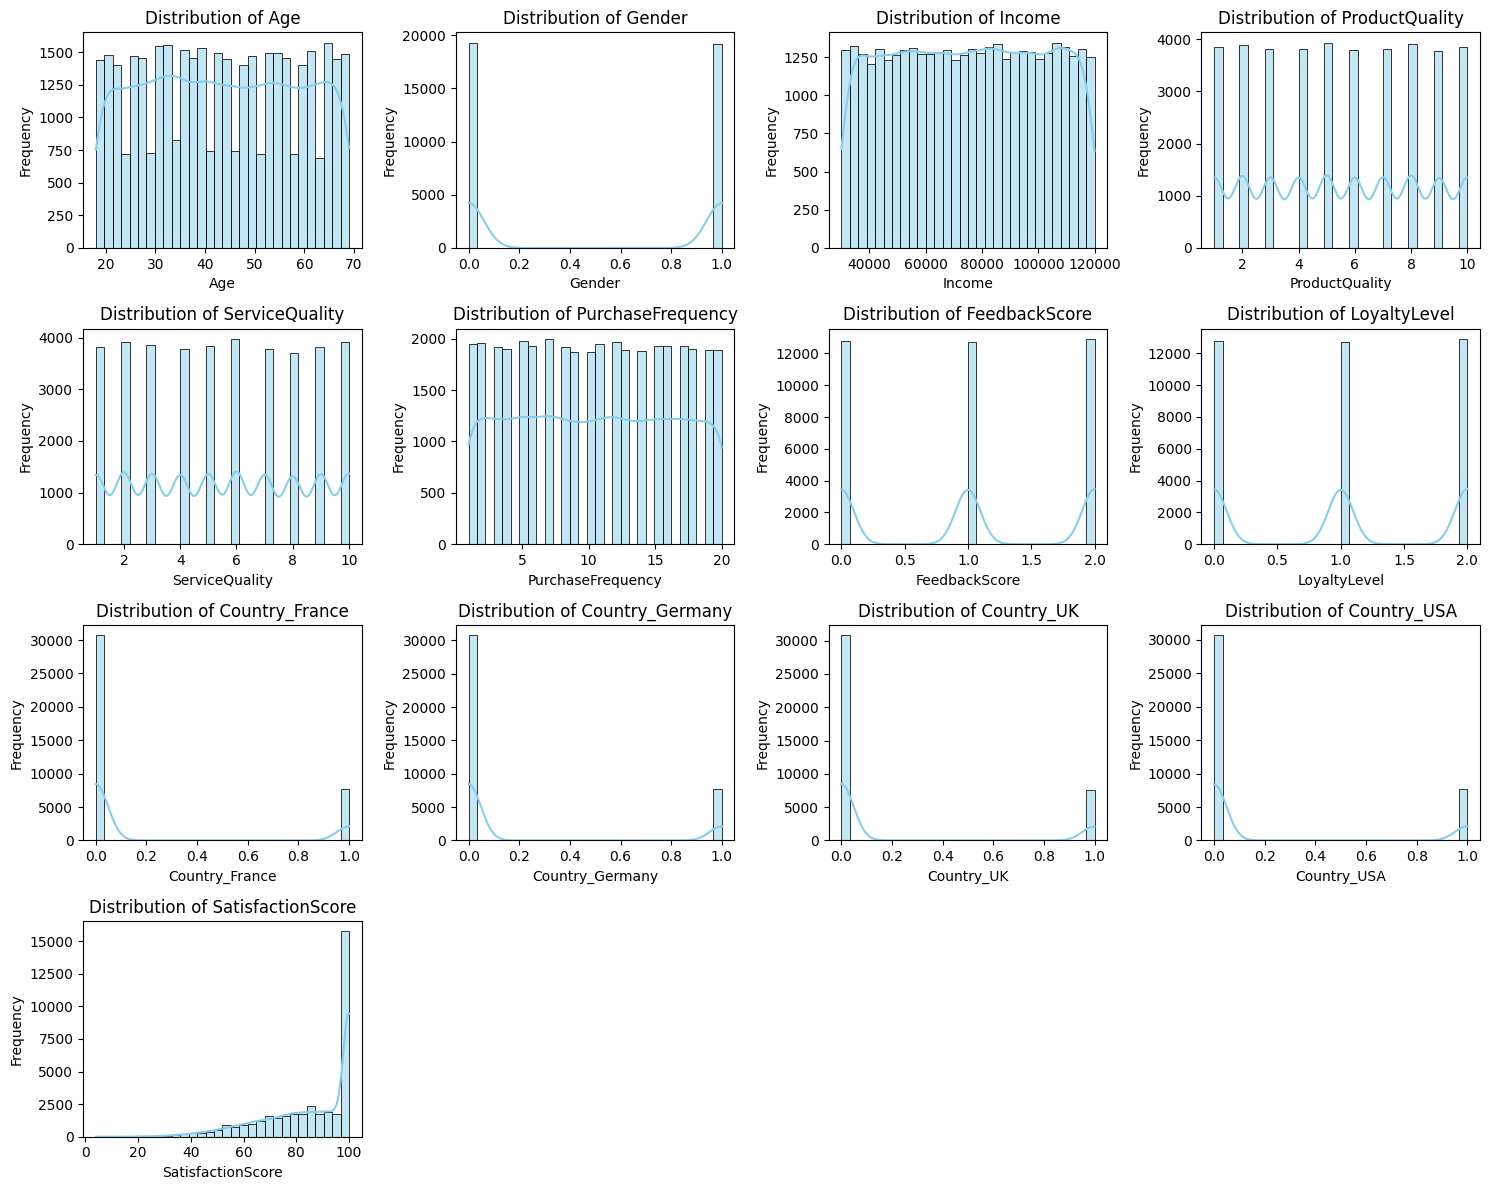

In [13]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(15, 12))
axes = axes.flatten()

for i, col in enumerate(df.columns):
    sns.histplot(df[col], kde=True, ax=axes[i], bins=30, color="skyblue")
    axes[i].set_title(f"Distribution of {col}")
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Frequency")

# Remove any extra subplots
for j in range(len(df.columns), len(axes)):
    fig.delaxes(axes[j])
fig.savefig("distribution_plots.png", format="png")
plt.tight_layout()
plt.show()

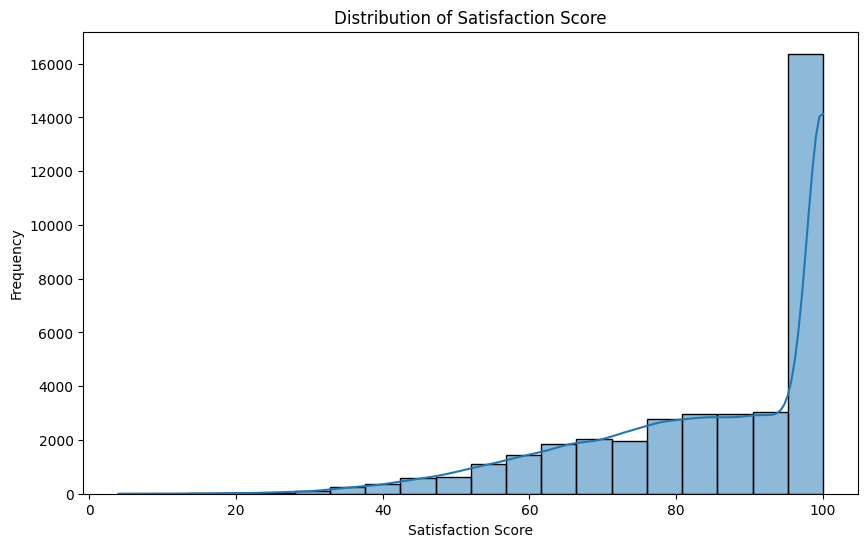

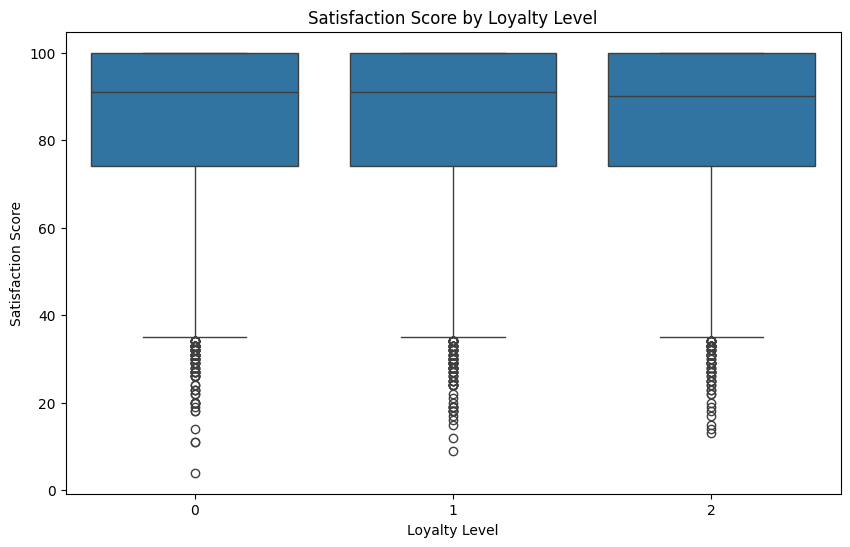

In [14]:
# Distribution of Satisfaction Score
plt.figure(figsize=(10, 6))
sns.histplot(df['SatisfactionScore'], bins=20, kde=True)
plt.title('Distribution of Satisfaction Score')
plt.xlabel('Satisfaction Score')
plt.ylabel('Frequency')
fig.savefig("satisfaction_distribution.png", format="png")
plt.show()

# Boxplot of Satisfaction Score by Loyalty Level
plt.figure(figsize=(10, 6))
sns.boxplot(x='LoyaltyLevel', y='SatisfactionScore', data=df)
plt.title('Satisfaction Score by Loyalty Level')
plt.xlabel('Loyalty Level')
plt.ylabel('Satisfaction Score')
plt.show()

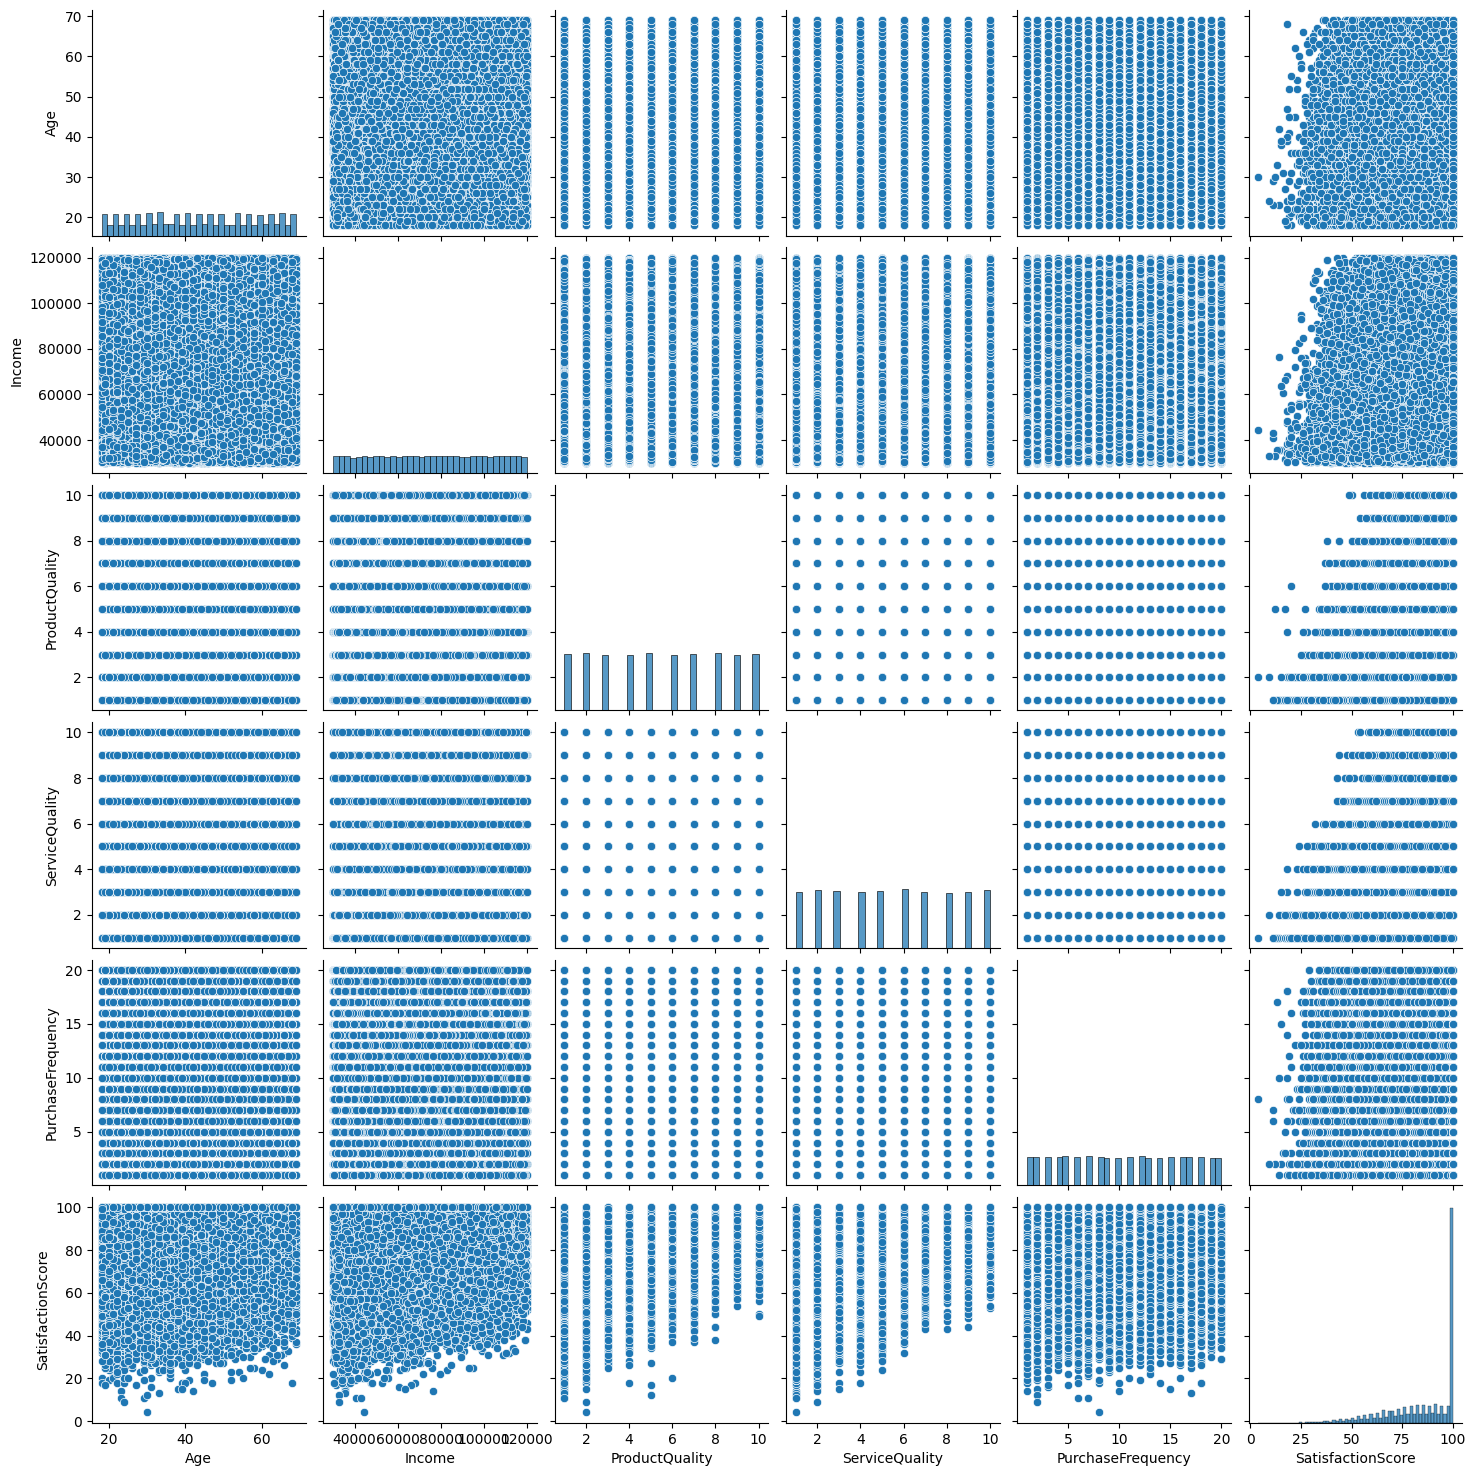

In [15]:
selected_features = ['Age', 'Income', 'ProductQuality', 'ServiceQuality', 'PurchaseFrequency', 'SatisfactionScore']
sns.pairplot(df[selected_features])
plt.show()

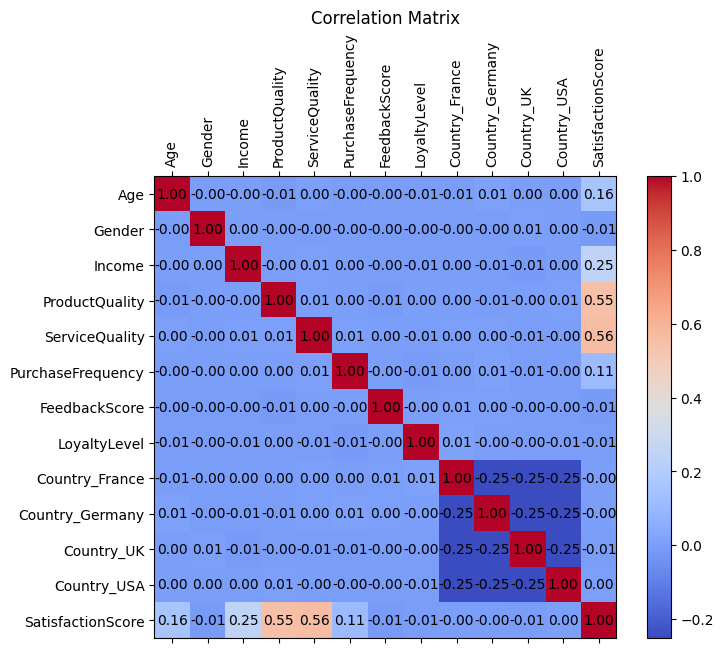

In [17]:
import matplotlib.pyplot as plt
import numpy as np

corr = df.corr()

fig, ax = plt.subplots(figsize=(8, 6))
cax = ax.matshow(corr, cmap='coolwarm')
fig.colorbar(cax)

for (i, j), val in np.ndenumerate(corr):
    ax.text(j, i, f'{val:.2f}', ha='center', va='center', color='black', fontsize=10)

plt.xticks(np.arange(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(np.arange(len(corr.columns)), corr.columns)
plt.title('Correlation Matrix')
plt.show()

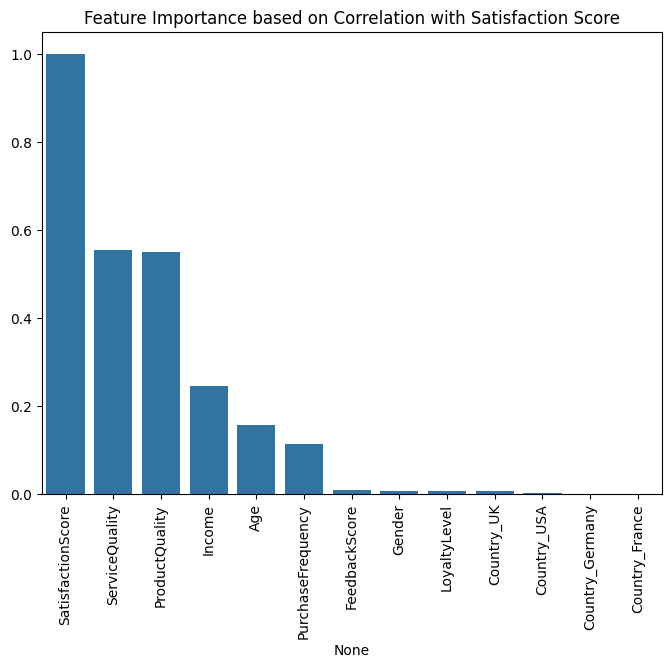

In [18]:
# Feature Importance using Correlation
plt.figure(figsize=(8,6))
sns.barplot(x=corr['SatisfactionScore'].abs().sort_values(ascending=False).index,
            y=corr['SatisfactionScore'].abs().sort_values(ascending=False).values)
plt.xticks(rotation=90)
plt.title('Feature Importance based on Correlation with Satisfaction Score')
plt.show()

In [19]:
X= df[['ServiceQuality', 'ProductQuality', 'Income', 'Age', 'PurchaseFrequency']]
y = df.iloc[:, -1]

In [20]:
# Applied log transformation to y if it's skewed
if abs(y.skew()) > 1:
    y = np.log1p(y)  # log(1 + y) to handle zero values safely

# Splitted the data into training, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Further splitted the training set into training and validation
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

# Standardized the data (scaling)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Defined models and hyperparameters for grid search
models = {
    'KNN Regressor': KNeighborsRegressor(),
    'Random Forest Regressor': RandomForestRegressor(),
    'Lasso Regression': Lasso()
}

param_grids = {
    'KNN Regressor': {
        'n_neighbors': [3, 5, 7, 10],
        'weights': ['uniform', 'distance'],
        'p': [1, 2]
    },
    'Random Forest Regressor': {
        'n_estimators': [50, 100, 200],
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5, 10]
    },
    'Lasso Regression': {
        'alpha': [0.01, 0.1, 1, 10]
    }
}

from sklearn.model_selection import KFold
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# To store results in a dictionary
model_results = {}
best_model = None
best_score = -np.inf
best_params = None

# Grid search for each model
for model_name, model in models.items():
    print(f"Grid search for {model_name}...")

    grid_search = GridSearchCV(estimator=model,
                               param_grid=param_grids[model_name],
                               cv=cv,
                               scoring='neg_mean_squared_error',
                               n_jobs=-1,
                               refit=True)

    # Fit model on scaled data for models that require scaling
    if model_name == 'KNN Regressor':  # KNN requires scaling
        grid_search.fit(X_train_scaled, y_train)
    else:
        grid_search.fit(X_train, y_train)

    print(f"Best parameters for {model_name}: {grid_search.best_params_}")

    # To record the best score and parameters
    best_model_score = grid_search.best_score_
    best_model_params = grid_search.best_params_

    model_results[model_name] = {
        'best_params': best_model_params,
        'best_score': best_model_score
    }

    # Evaluated on validation set
    y_val_pred = grid_search.best_estimator_.predict(X_val_scaled if model_name == 'KNN Regressor' else X_val)

    mse = mean_squared_error(y_val, y_val_pred)
    r2 = r2_score(y_val, y_val_pred)

    print(f"Validation Set - {model_name}: MSE = {mse:.2f}, R² = {r2:.2f}")

    # Tracking the best model based on the best validation score
    if best_model_score > best_score:
        best_score = best_model_score
        best_params = best_model_params
        best_model = grid_search.best_estimator_

# Evaluating the best model on the test set
print(f"\nBest Model: {best_model}")
y_test_pred = best_model.predict(X_test_scaled if isinstance(best_model, KNeighborsRegressor) else X_test)

test_mse = mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f"Test Set - Best Model: MSE = {test_mse:.2f}, R² = {test_r2:.2f}")

# Displaying all results for comparison
model_results_df = pd.DataFrame(model_results).T
print("\nModel Selection Results:")
print(model_results_df)

Grid search for KNN Regressor...
Best parameters for KNN Regressor: {'n_neighbors': 10, 'p': 1, 'weights': 'uniform'}
Validation Set - KNN Regressor: MSE = 0.01, R² = 0.75
Grid search for Random Forest Regressor...
Best parameters for Random Forest Regressor: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 200}
Validation Set - Random Forest Regressor: MSE = 0.01, R² = 0.76
Grid search for Lasso Regression...
Best parameters for Lasso Regression: {'alpha': 0.01}
Validation Set - Lasso Regression: MSE = 0.02, R² = 0.65

Best Model: RandomForestRegressor(max_depth=10, min_samples_split=5, n_estimators=200)
Test Set - Best Model: MSE = 0.01, R² = 0.76

Model Selection Results:
                                                               best_params  \
KNN Regressor            {'n_neighbors': 10, 'p': 1, 'weights': 'uniform'}   
Random Forest Regressor  {'max_depth': 10, 'min_samples_split': 5, 'n_e...   
Lasso Regression                                           {'alpha': 0.01

In [21]:
# Training the RandomForestRegressor with the best parameters
rf = RandomForestRegressor(max_depth=10, min_samples_split=10, n_estimators=200, random_state=42)
rf.fit(X_train, y_train)

# Evaluating the model on the validation set
y_val_pred = rf.predict(X_val)
val_mse = mean_squared_error(y_val, y_val_pred)
val_r2 = r2_score(y_val, y_val_pred)

print(f"Validation Set - RandomForestRegressor: MSE = {val_mse:.2f}, R² = {val_r2:.2f}")
# Evaluating the model on the test set
y_test_pred = rf.predict(X_test)
test_mse = mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f"Test Set - RandomForestRegressor: MSE = {test_mse:.2f}, R² = {test_r2:.2f}")

Validation Set - RandomForestRegressor: MSE = 0.01, R² = 0.76
Test Set - RandomForestRegressor: MSE = 0.01, R² = 0.76


In [22]:
# Making predictions on the test set
y_test_pred = rf.predict(X_test)

predictions_df = pd.DataFrame({
    'Actual': np.exp(y_test),
    'Predicted': np.exp(y_test_pred)
})
print(predictions_df.head(30))


       Actual   Predicted
10312    89.0   78.787395
18970   101.0   99.666036
36401   101.0   99.537751
9289     85.0   77.997944
31854   101.0   99.980405
30068    80.0   72.455647
13974    83.0   74.566775
2189     83.0   98.530162
3732     68.0   70.911055
8528     90.0   85.061599
34369    63.0   60.780826
28291    80.0   94.155269
17735    57.0   81.146141
21628   101.0   90.284035
15280   101.0   89.958724
35707   101.0   97.780795
29960   101.0  100.860713
25899    74.0   77.631513
20252    92.0   77.332497
9049    101.0   91.275682
15469    75.0   86.044550
14603    83.0   94.413302
6736     88.0   89.611443
2055     75.0   88.035366
8647     78.0   88.228699
24492    72.0   79.656074
34524    63.0   65.235408
25295    97.0   87.826793
27552   101.0  100.748564
25350    74.0   82.128927


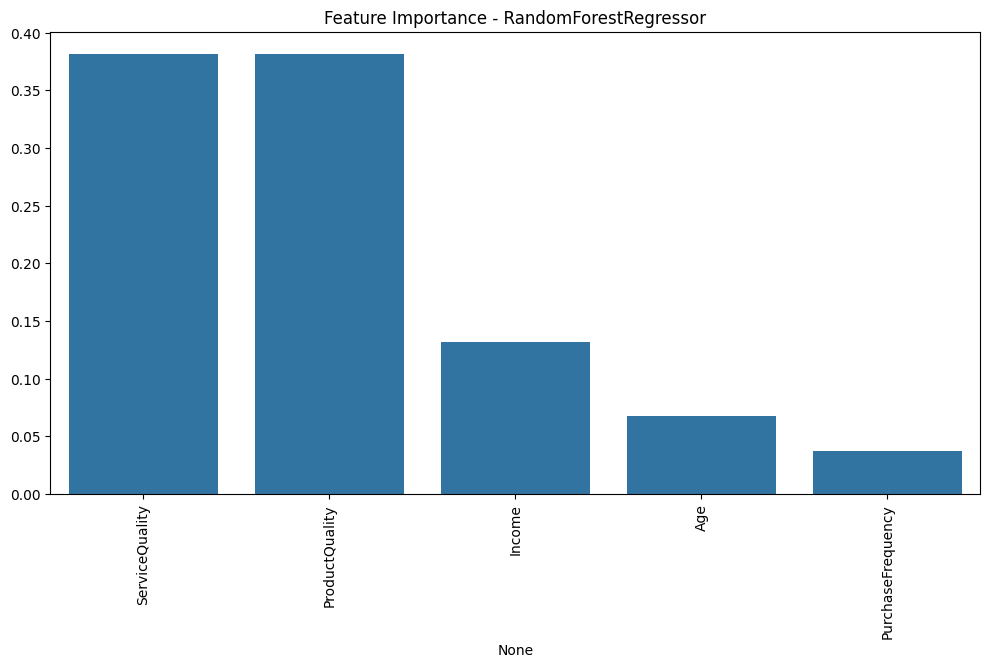

In [23]:
# Plot the feature importance
feature_importance = rf.feature_importances_
features = X.columns

plt.figure(figsize=(12, 6))
sns.barplot(x=features, y=feature_importance)
plt.xticks(rotation=90)
plt.title('Feature Importance - RandomForestRegressor')
plt.show()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/200
676/676 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.8852 - mae: 1.7449
Epoch 1: val_loss improved from inf to 0.23458, saving model to best_regression_model.keras
676/676 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 4.8813 - mae: 1.7440 - val_loss: 0.2346 - val_mae: 0.3893
Epoch 2/200
647/676 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8024 - mae: 0.7159
Epoch 2: val_loss improved from 0.23458 to 0.08379, saving model to best_regression_model.keras
676/676 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7988 - mae: 0.7143 - val_loss: 0.0838 - val_mae: 0.2437
Epoch 3/200
676/676 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5851 - mae: 0.6118
Epoch 3: val_loss improved from 0.08379 to 0.05565, saving model to best_regression_model.keras
676/676 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.5850 - mae: 0.6118 - val_loss: 0.0556 - val_mae: 0.2052
Epoch 4/200
665/676 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4643 - mae: 0.5439
Epoch 4: val_loss improved from 0.05565 to 0.01767, saving model to

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 64)                  │             384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,493 (29.27 KB)

 Trainable params: 2,497 (9.75 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 4,996 (19.52 KB)

None


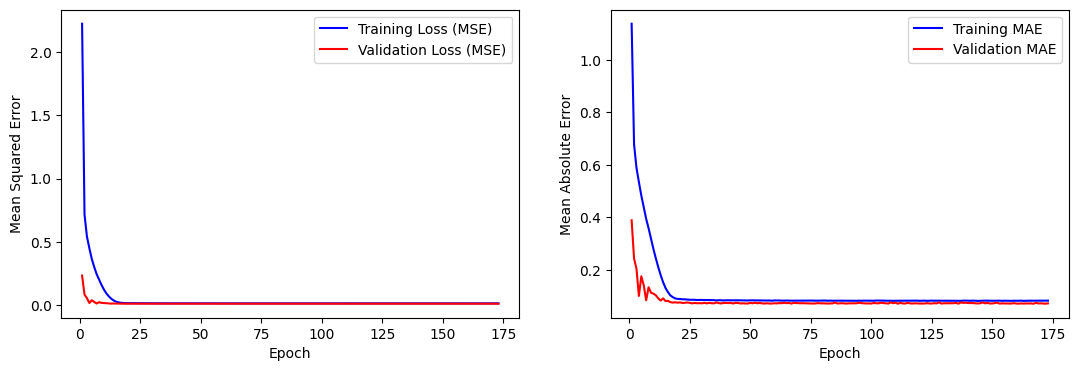

301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Test Set - Neural Network: MSE = 0.01, R² = 0.78


In [28]:
# Seed for reproducibility
seed_value = 42
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

# Splitting the data into training, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

# Scaling the data (important for neural networks)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

regression_model = keras.Sequential([
    layers.Dense(64, activation="relu", input_shape=(X_train_scaled.shape[1],)),
    layers.Dropout(0.3),
    layers.Dense(32, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(1)  # Output layer for regression
])

regression_model.compile(optimizer="adam", loss="mse", metrics=["mae"])

# Defining callbacks for early stopping and model checkpoint
my_callbacks = [
    keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=20,
        restore_best_weights=True
    ),
    keras.callbacks.ModelCheckpoint(
        filepath="best_regression_model.keras",
        monitor="val_loss",
        save_best_only=True,
        verbose=1
    )
]

# Training the model
start = time.time()
history = regression_model.fit(
    x=X_train_scaled,
    y=y_train,
    batch_size=32,
    epochs=200,
    validation_data=(X_val_scaled, y_val),
    callbacks=my_callbacks
)
end = time.time()
training_duration = end - start
print("Training duration = {:.3f} seconds".format(training_duration))
print(history.history.keys())
print(regression_model.summary())

# Plotting the training and validation loss/metrics
epoch_count = range(1, len(history.history['loss']) + 1)
plt.figure(figsize=(13, 4))

# Loss Plot
plt.subplot(121)
plt.plot(epoch_count, history.history['loss'], 'b', label='Training Loss (MSE)')
plt.plot(epoch_count, history.history['val_loss'], 'r', label='Validation Loss (MSE)')
plt.legend()
plt.ylabel('Mean Squared Error')
plt.xlabel('Epoch')

# MAE Plot
plt.subplot(122)
plt.plot(epoch_count, history.history['mae'], 'b', label='Training MAE')
plt.plot(epoch_count, history.history['val_mae'], 'r', label='Validation MAE')
plt.legend()
plt.ylabel('Mean Absolute Error')
plt.xlabel('Epoch')

plt.show()

# Evaluating the model on the test set
y_test_pred = regression_model.predict(X_test_scaled)
test_mse = mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f"Test Set - Neural Network: MSE = {test_mse:.2f}, R² = {test_r2:.2f}")
